In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [82]:
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
seed_everything(0)

In [83]:
BASE_DIR = '/content/drive/MyDrive/data_feed/'
# Set the hyperparameters
HIDDEN_SIZE = 32
NUM_EPOCHS = 80
LAG = 10
N_STOCK = 20
BATCH_SIZE = 64
NUM_LAYERS = 2
NUM_HEADS = 1
DROPOUT = 0.1
LOG_FREQUENCY = 10
PREPROCESS_DATA = False

In [84]:
device = torch.device("cpu")
if torch.cuda.is_available():
   device = torch.device("cuda")

# Definition of the models and functions

In [85]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_layer = nn.Linear(input_size, 128)
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=1,kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=2, padding=1)
        )
        self.lstm = nn.LSTM(64, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        x = self.input_layer(x)
        x = self.conv(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out


In [86]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, num_layers, output_size, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.num_layers = num_layers

        self.embedding = nn.Linear(input_size, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(hidden_size, num_heads, dropout=dropout),
            num_layers
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        x = self.fc(x[:, -1, :])  # Get the last time step output
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_length=1000):
        super(PositionalEncoding, self).__init__()

        position = torch.arange(0, max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2) * -(math.log(10000.0) / hidden_size))
        pe = torch.zeros(max_length, hidden_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

In [87]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

In [88]:
def training(data: DataLoader, model, criterion, optimizer, input_size):
    # Training loop
    running_loss = 0.
    last_loss = 0.
    model.train()
    for epoch in range(NUM_EPOCHS):
        for i, batch in enumerate(data):
            X, y = batch
            X = X.unsqueeze(1)
            y = y.unsqueeze(1)
            predict = model(X)
            loss = criterion(predict, y)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            running_loss += loss.item()

        if (epoch + 1) % LOG_FREQUENCY == 0:
            last_loss = running_loss/LOG_FREQUENCY
            print(f'Epoch: {epoch + 1}/{NUM_EPOCHS}, Loss: {last_loss}')
            running_loss = 0


def testing(data: DataLoader, model):
    # Generate predictions
    model.eval()
    predictions = []
    with torch.no_grad():
        for i, batch in enumerate(data):
            X, y = batch
            X = X.unsqueeze(1)
            y = y.unsqueeze(1)
            predict = model(X)
            predictions.append(predict.detach().cpu().numpy())
    
    return predictions


# Data Preprocessing

In [89]:
# check if data_feed directory exist if not 
# assert os.path.exists(BASE_DIR)
# list all the files in the data_feed directory
files = os.listdir(BASE_DIR)

# Data Processing for the model

In [90]:
def rename_columns(df: pd.DataFrame, file_name: str) -> None:
    """
    modify columns names (exept date) into the following structure: 
        *column_name*_*stock_name* 
        
    Example: Open_AAPL
    """
    df.rename(columns=dict(zip(df.columns[1:], df.columns[1:] + '_' + file_name[:-4])), inplace=True)

In [91]:
if PREPROCESS_DATA:
    # Read First File into a pandas dataframe
    df = pd.read_csv(BASE_DIR+files[0])
    rename_columns(df, files[0])

    # Merge Everything into a unique DataFrame
    for fn in files[1:]:
        df2 = pd.read_csv(BASE_DIR+fn)
        rename_columns(df2, fn)
        result = df.merge(df2, on='Date')
        df = result

    df.set_index('Date',inplace=True)
    df.index = pd.to_datetime(df.index)

    cols = [col for col in df.columns if "Adj Close" in col]
    df = df[cols]


    # Save all the data onto a file
    df.to_csv('AGGREGATED_DATA.csv')

    split_date = df.index[0] + pd.offsets.DateOffset(years=8)
    train_data = df[df.index <= split_date]
    test_data = df[df.index > split_date]
    test_data.to_csv('TEST.csv')
    train_data.to_csv('TRAIN.csv')
else:
    test_data = pd.read_csv('/content/drive/MyDrive/TEST.csv')
    test_data.set_index('Date',inplace=True)
    train_data = pd.read_csv('/content/drive/MyDrive/TRAIN.csv')
    train_data.set_index('Date',inplace=True)

In [92]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data.values)
scaled_test = scaler.transform(test_data.values)
scaled_test = np.vstack((scaled_train[-LAG:, :], scaled_test))

In [93]:
class TimeSeriesdataset(Dataset):
    def __init__(self, lag: int, data: np.ndarray, device: torch.device):
        self.lag = lag
        self.data = data
        self.device = device

    def __len__(self):
        lenght = len(self.data)
        return lenght - (self.lag + 1)

    def __getitem__(self, idx):
        X = self.data[idx:idx+self.lag, :].flatten()
        Y = self.data[idx+self.lag, :]
        return torch.tensor(X, device=self.device).to(torch.float32), torch.tensor(Y, device=self.device).to(torch.float32)

In [94]:
train_dataset = TimeSeriesdataset(lag=LAG, data=scaled_train, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TimeSeriesdataset(lag=LAG, data=scaled_test, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model, training and testing

In [95]:
# Create the LSTM model
modelLSTM = LSTM(input_size=LAG*N_STOCK, hidden_size=HIDDEN_SIZE, output_size=N_STOCK).to(device)
modelTransformer = TransformerModel(input_size=LAG*N_STOCK, hidden_size=HIDDEN_SIZE, output_size=N_STOCK, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, dropout=DROPOUT).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizerLSTM = optim.Adam(modelLSTM.parameters())
optimizerTransformer = optim.Adam(modelTransformer.parameters())

In [96]:
# LSTM_train = training(train_dataloader, modelLSTM, criterion, optimizerLSTM, input_size=LAG*N_STOCK)
print('*'*50)
Transformer_train = training(train_dataloader, modelTransformer, criterion, optimizerTransformer, input_size=LAG*N_STOCK)

**************************************************


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 1, 20])) that is different to the input size (torch.Size([64, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([20, 1, 20])) that is different to the input size (torch.Size([20, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10/80, Loss: 1.8160153713077307
Epoch: 20/80, Loss: 0.6637918875552714
Epoch: 30/80, Loss: 0.6291010592598468
Epoch: 40/80, Loss: 0.6556342325173319
Epoch: 50/80, Loss: 0.5516984756104648
Epoch: 60/80, Loss: 0.861811965284869
Epoch: 70/80, Loss: 0.752101811231114
Epoch: 80/80, Loss: 0.6475691067054867


In [97]:
LSTM_test = testing(test_dataloader, modelLSTM)
Transformer_test = testing(test_dataloader, modelTransformer)

# Plots

In [98]:
def plot_predictions(predictions):
    # join everything into a unique matrix
    all_pred = np.zeros(N_STOCK)
    for b in predictions:
        for p in b:
            all_pred = np.vstack((all_pred, p))
    # Remove zero vector
    all_pred = all_pred[1:, :]
    all_pred = scaler.inverse_transform(all_pred)

    all_real = np.concatenate((scaled_train, scaled_test))
    all_real = scaler.inverse_transform(all_real)
    all_real.shape[0]

    # idx = 0
    for idx, file_name in enumerate(files):
        stock = file_name[:-4]
        index_test_start = all_real[:, 0].shape[0] - all_pred.shape[0]
        plt.figure()
        plt.plot( range(all_real.shape[0]) , all_real[:, idx], label='real')
        plt.plot( range(index_test_start,all_real.shape[0]), all_pred[:, idx], color='orange', label='forecast')
        plt.axvline(x=index_test_start, color='red', linestyle='--')
        plt.title(stock)
        plt.legend()
        plt.show()


In [99]:
plot_predictions(LSTM_test)

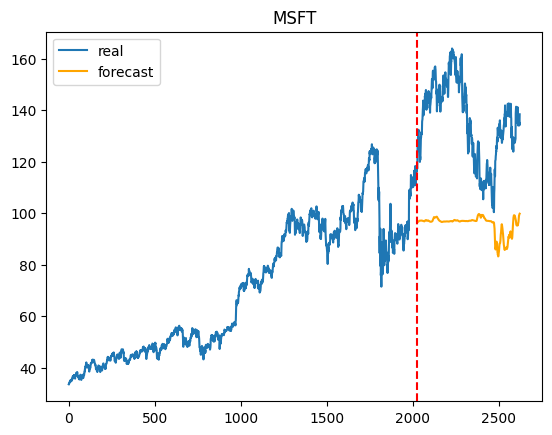

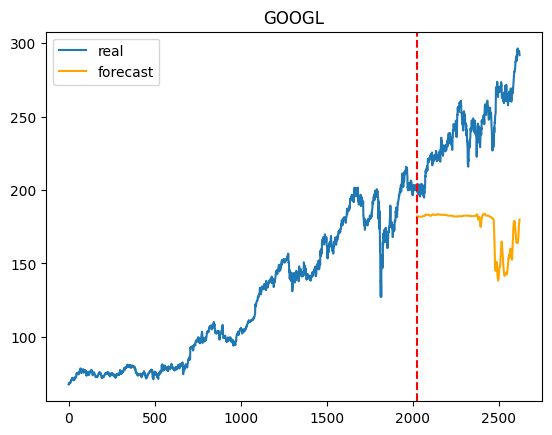

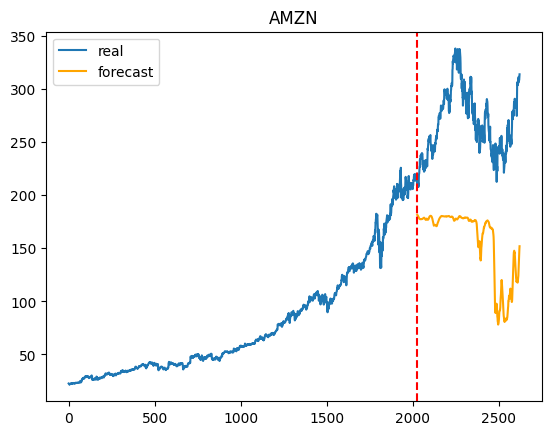

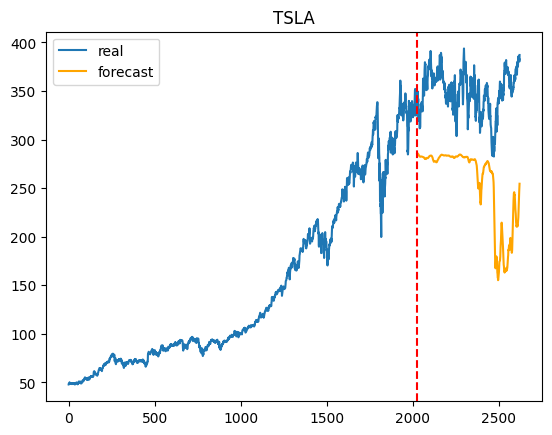

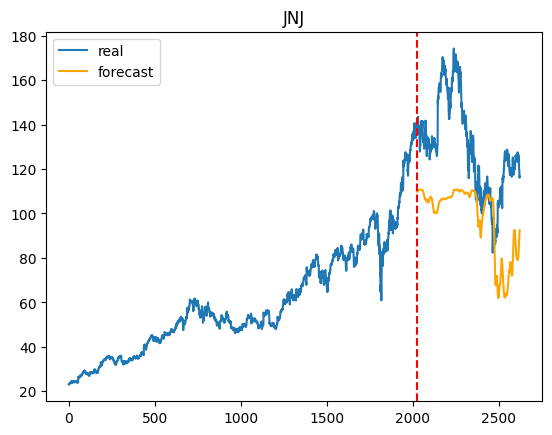

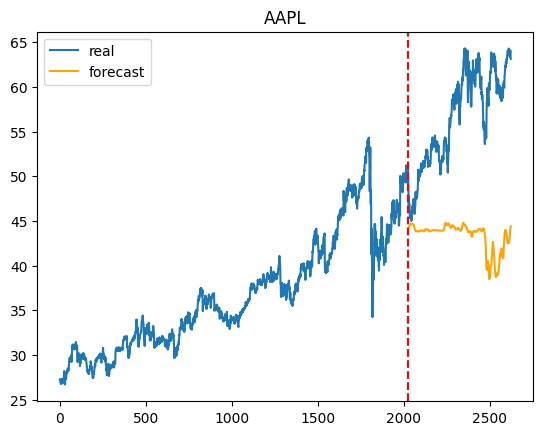

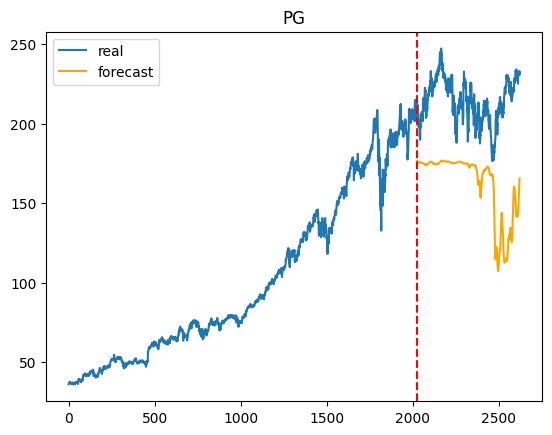

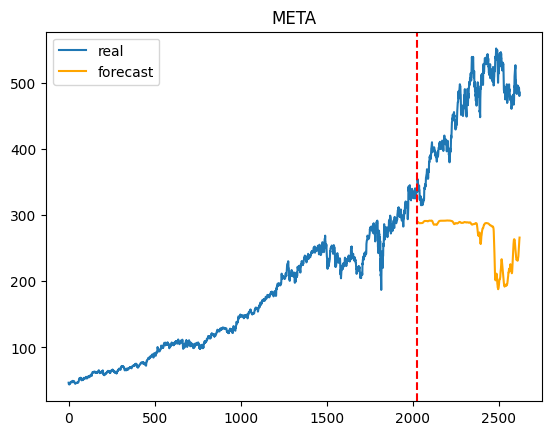

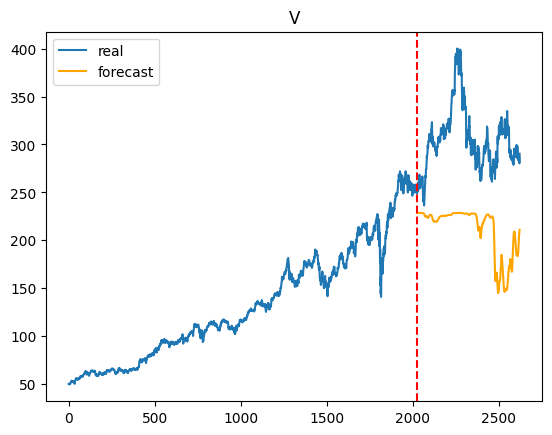

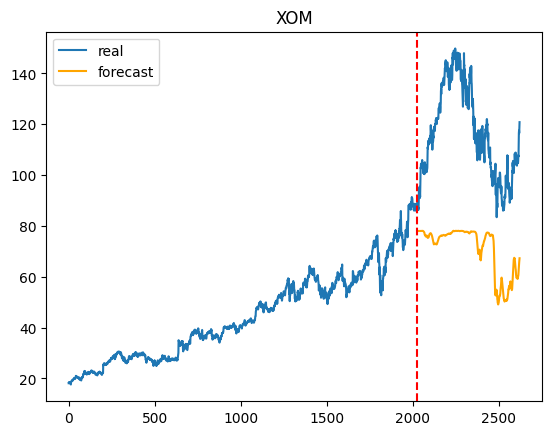

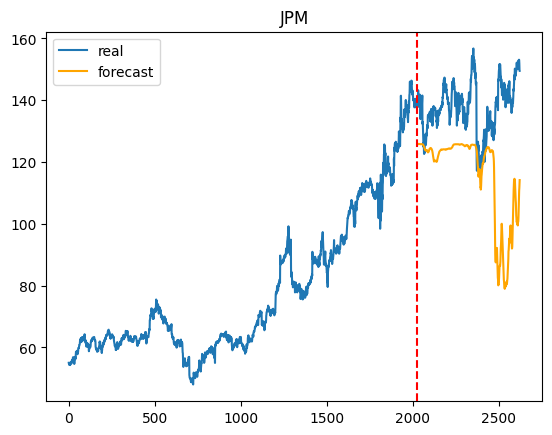

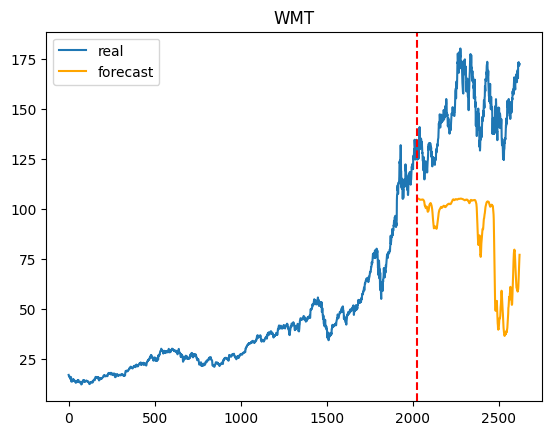

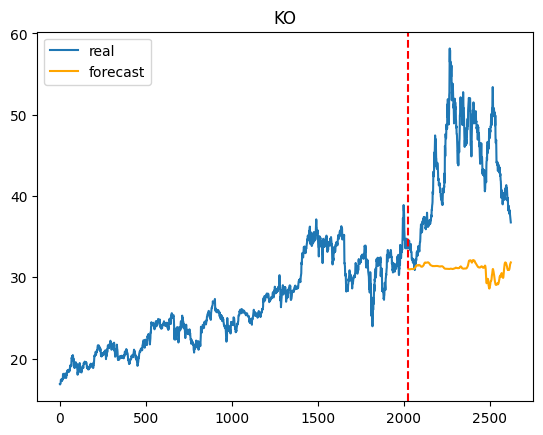

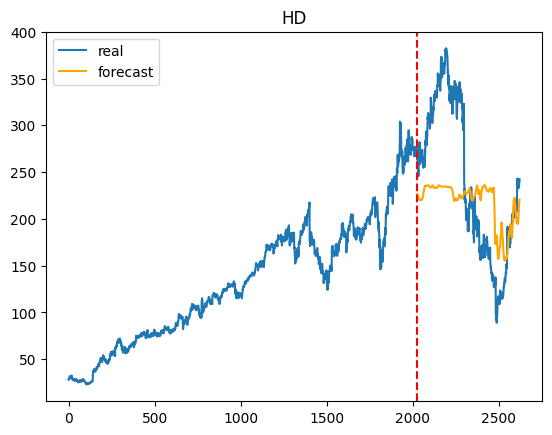

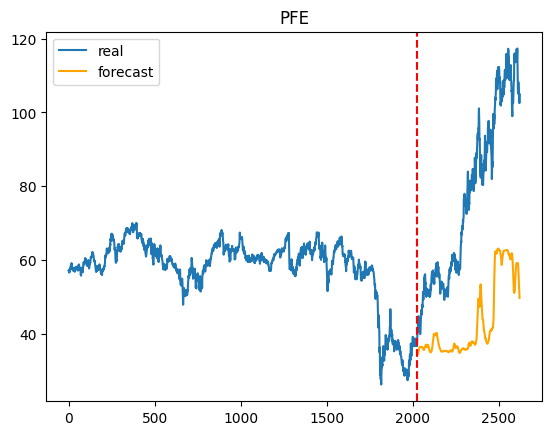

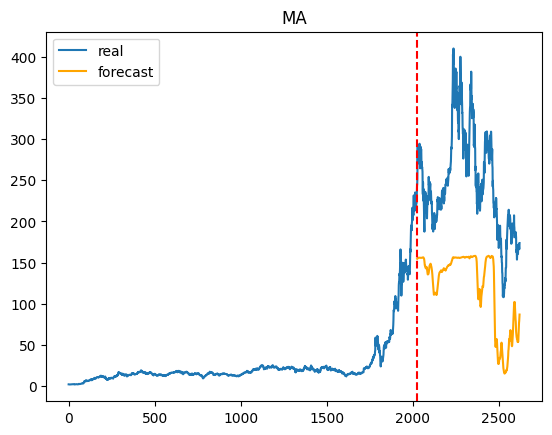

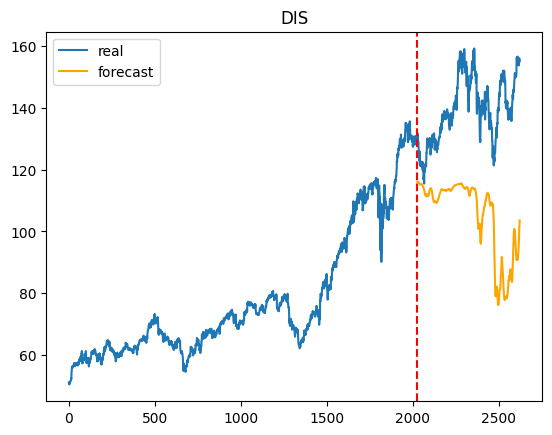

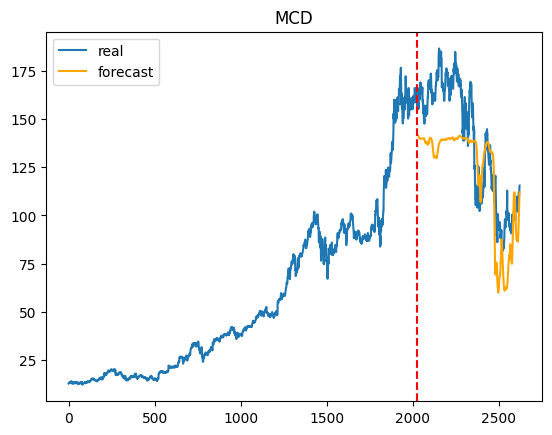

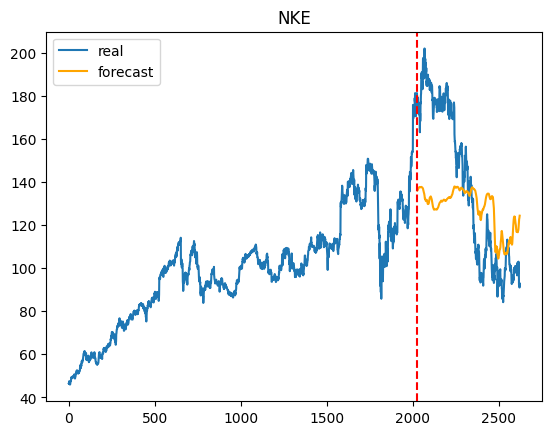

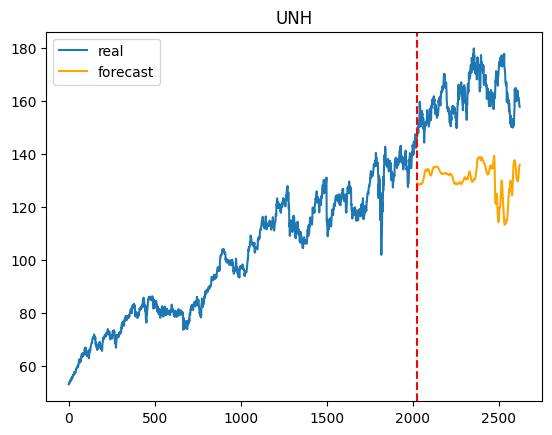

In [100]:
plot_predictions(Transformer_test)